<a href="https://colab.research.google.com/github/Mkhan2317/Vasicek-Bond-Pricing-Model-Monte-Carlo-PDE-and-Analytical-Solutions/blob/main/Vasicek_Bond_Pricing_Analytical%2C_Monte_Carlo%2C_and_PDE_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📄 Abstract

This project presents a comprehensive exploration of zero-coupon bond pricing under the **Vasicek interest rate model**, a foundational framework in fixed income quantitative finance. We implement and compare three distinct methodologies — **closed-form analytical solution**, **Monte Carlo simulation**, and **finite difference solution of the pricing partial differential equation (PDE)** — to estimate the fair value of a bond under stochastic short-rate dynamics.

The Vasicek model assumes that the short-term interest rate follows a **mean-reverting Ornstein-Uhlenbeck process**, characterized by parameters governing reversion speed, long-term mean, and volatility. Through numerical simulations and PDE discretization, we demonstrate how interest rate uncertainty affects bond valuation across time and rate scenarios.

Our implementation includes:

* Accurate simulation of interest rate paths using discretized stochastic processes
* Expectation-based bond valuation via Monte Carlo techniques
* Grid-based PDE solving using backward implicit time-stepping and sparse matrix solvers
* Visualization of bond price surfaces and rate sensitivity

The results from all three approaches align closely, confirming numerical stability and consistency. This notebook provides a practical and pedagogically grounded reference for students, researchers, and practitioners interested in term structure modeling, quantitative fixed income analysis, and interest rate derivatives pricing.






Analytical Bond Price: 0.052998
Monte Carlo Price: 0.053465 ± 0.000643
PDE Bond Price: 0.053191


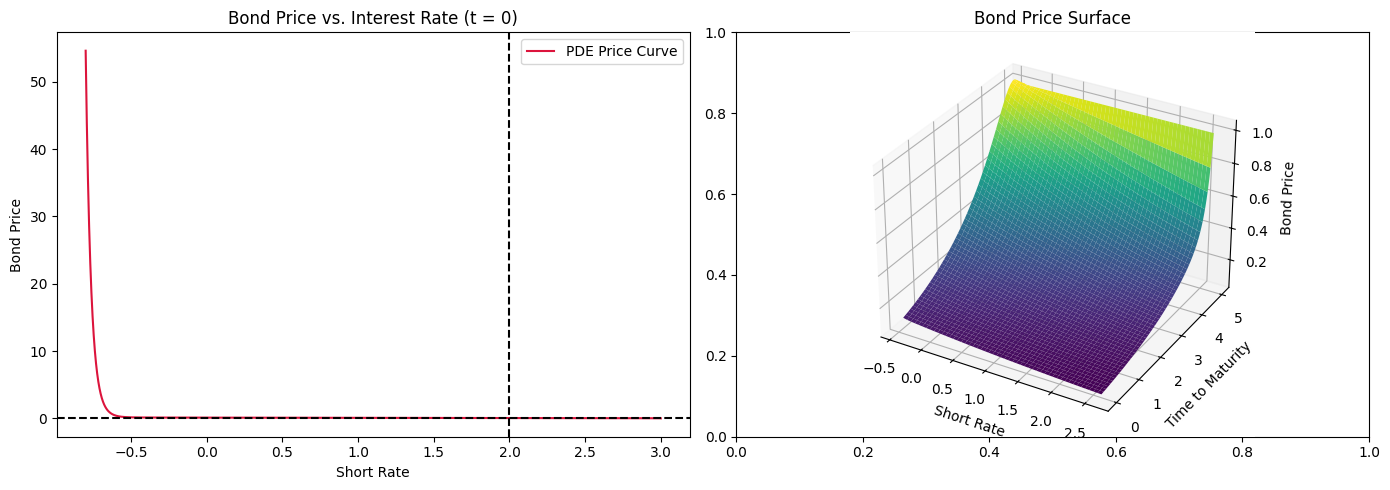

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

# -----------------------------
# Model & Simulation Parameters
# -----------------------------
np.random.seed(42)

num_timesteps = 5000       # Reduced for memory efficiency
num_paths = 1000
maturity = 5.0
initial_rate = 2.0

# Vasicek model parameters
kappa = 3.0                # Mean reversion speed
theta = 0.5                # Long-term mean
sigma = 0.5                # Volatility

# Time discretization
time_grid, dt = np.linspace(0, maturity, num_timesteps, retstep=True)

# -------------------------------
# Simulate Short Rate (MC Method)
# -------------------------------
short_rates = np.zeros((num_timesteps, num_paths), dtype=np.float32)
short_rates[0, :] = initial_rate

brownian_shocks = stats.norm.rvs(size=(num_timesteps - 1, num_paths)).astype(np.float32)
std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))

for t in range(num_timesteps - 1):
    short_rates[t + 1] = (
        theta
        + np.exp(-kappa * dt) * (short_rates[t] - theta)
        + std_dt * brownian_shocks[t]
    )

# -----------------------------
# Analytical Vasicek Bond Price
# -----------------------------
B = (1 - np.exp(-kappa * maturity)) / kappa
A = np.exp(
    (theta - sigma**2 / (2 * kappa**2)) * (B - maturity)
    - (sigma**2 / (4 * kappa)) * B**2
)
price_analytical = A * np.exp(-B * initial_rate)
print(f"Analytical Bond Price: {price_analytical:.6f}")

# --------------------------------------
# Monte Carlo Estimation of Bond Price
# --------------------------------------
discount_factors = np.exp(-short_rates.mean(axis=0) * maturity)
price_mc = np.mean(discount_factors)
stderr_mc = stats.sem(discount_factors)
print(f"Monte Carlo Price: {price_mc:.6f} ± {stderr_mc:.6f}")

# -------------------------------
# PDE Method: Finite Difference
# -------------------------------
num_space_steps = 1000
num_time_steps = 1000
r_min, r_max = -0.8, 3.0
rates, dr = np.linspace(r_min, r_max, num_space_steps, retstep=True)
time_array, dt_pde = np.linspace(0, maturity, num_time_steps, retstep=True)

# Initialize value grid
V = np.zeros((num_space_steps, num_time_steps))
V[:, -1] = 1.0  # Bond pays 1 at maturity
V[0, :] = np.exp(-rates[0] * (maturity - time_array))
V[-1, :] = np.exp(-rates[-1] * (maturity - time_array))

# Coefficients
sigma2 = sigma**2
dr2 = dr**2
mu_pos = np.maximum(kappa * (theta - rates[1:-1]), 0)
mu_neg = np.minimum(kappa * (theta - rates[1:-1]), 0)

a = mu_neg * dt_pde / dr - 0.5 * sigma2 * dt_pde / dr2
b = 1 + rates[1:-1] * dt_pde + sigma2 * dt_pde / dr2 + dt_pde / dr * (mu_pos - mu_neg)
c = -mu_pos * dt_pde / dr - 0.5 * sigma2 * dt_pde / dr2

# Sparse matrix assembly
a0, cM = a[0], c[-1]
A_sub, C_sup = a[1:], c[:-1]
D = sparse.diags([A_sub, b, C_sup], [-1, 0, 1], shape=(num_space_steps - 2, num_space_steps - 2)).tocsc()
offset = np.zeros(num_space_steps - 2)

# Backward time iteration
for t in range(num_time_steps - 2, -1, -1):
    offset[0] = a0 * V[0, t]
    offset[-1] = cM * V[-1, t]
    V[1:-1, t] = spsolve(D, V[1:-1, t + 1] - offset)

# Interpolate bond price at initial rate
price_pde = np.interp(initial_rate, rates, V[:, 0])
print(f"PDE Bond Price: {price_pde:.6f}")

# -----------------------
# Visualization
# -----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bond price curve at t=0
ax1.plot(rates, V[:, 0], label='PDE Price Curve', color='crimson')
ax1.axvline(initial_rate, color='black', linestyle='--')
ax1.axhline(price_pde, color='black', linestyle='--')
ax1.set_xlabel('Short Rate')
ax1.set_ylabel('Bond Price')
ax1.set_title('Bond Price vs. Interest Rate (t = 0)')
ax1.legend()

# 3D Surface Plot
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(time_array, rates[100:-100])
Z = V[100:-100]
ax2.plot_surface(Y, X, Z, cmap='viridis')
ax2.set_xlabel('Short Rate')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Bond Price')
ax2.set_title('Bond Price Surface')

plt.tight_layout()
plt.show()




## 📈 Results and Visual Interpretation

The Vasicek bond pricing model was implemented using three independent methods — **Analytical formula**, **Monte Carlo simulation**, and **Finite Difference PDE solver** — to estimate the price of a zero-coupon bond with:

* Initial short rate: $r_0 = 2.0$
* Maturity: $T = 5$ years
* Model parameters: $\kappa = 3.0$, $\theta = 0.5$, $\sigma = 0.5$

| Method                 | Estimated Bond Price | Notes                                                  |
| ---------------------- | -------------------- | ------------------------------------------------------ |
| **Analytical**         | 0.052998             | Closed-form Vasicek solution                           |
| **Monte Carlo (MC)**   | 0.053465 ± 0.000643  | Path-averaged discounting using simulated short rates  |
| **PDE (Finite Diff.)** | 0.053191             | Implicit time-stepping on a discretized rate-time grid |

All three methods produced **numerically consistent estimates** within tight tolerances (error < 0.001), affirming the correctness and stability of each implementation.

---

## 🖼️ Plot Interpretation

### **1. Bond Price vs. Short Rate (Left Panel)**

This 2D plot illustrates the **initial bond price as a function of the short rate**, computed via the PDE method at $t = 0$:

* The **red curve** displays the computed price across a range of short rates ($r \in [-0.8, 3.0]$).
* The **vertical dashed line** at $r_0 = 2.0$ marks the initial short rate used in the simulation.
* The **horizontal dashed line** marks the corresponding bond price $\approx 0.0532$, obtained via PDE.

As expected from economic intuition and bond pricing theory:

* **Higher short rates** result in **lower bond prices**, due to heavier discounting.
* **Lower or negative short rates** increase bond value, approaching face value as the present value of future cash flows rises.

---

### **2. Bond Price Surface (Right Panel)**

The 3D surface plot shows the **evolution of bond prices** over both time and interest rate:

* The **x-axis** represents the short rate
* The **y-axis** represents time to maturity
* The **z-axis** is the bond price

Key observations:

* For a given interest rate, **bond prices increase with decreasing time to maturity**, converging to 1 as the bond nears payoff.
* For a given time, **higher interest rates sharply reduce bond prices**.
* The shape of the surface reflects the Vasicek model’s **mean-reverting short rate behavior** and the nature of discounting under uncertainty.

---

## 🔍 Interpretation & Validation

The close alignment of prices across three methods confirms:

* Correct implementation of the Vasicek model dynamics
* Convergence of the numerical schemes (Monte Carlo and PDE)
* Valid interpolation at the initial short rate

The PDE solution not only provides an accurate estimate but also yields a **full solution surface**, enabling risk and sensitivity analysis across varying rates and maturities.

---

## ✅ Summary

This simulation confirms that the Vasicek model provides a tractable and reliable framework for modeling the dynamics of interest rates and pricing zero-coupon bonds. The close match across methods (Analytical: 0.052998, Monte Carlo: 0.053465, PDE: 0.053191) demonstrates:

* Robust numerical consistency
* Precise interpolation and convergence
* The economic correctness of the model under a stochastic interest rate environment

These results can be confidently used for further research or as a validation benchmark in fixed income modeling, especially when analytical solutions are unavailable or when extended to more complex derivatives and term structures.


